# 0. Introduction

2024.10.02  
딥러닝 응용 수업 Autoencoder 발표용으로 만든 notebook. 추가 수정 예정  


**References**  
[Extreme Rare Event Classification using Autoencoders in Keras | by Chitta Ranjan | Towards Data Science](https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098)

**Background**  
우리가 실제로 task를 수행할 real world에서는 **rare-event problem**이 굉장히 많다.  
bigdata 세상이라 large data를 구할 수 있는데, large가 중요한 게 아니다. positively labeled samples가 얼마나 많냐가 Classifying을 잘 할 수 있는 핵심이다.
- **rare-event problem**  
  unbalanced dataset. fewer positively labeled samples than negative. normaly, positive labeled data are around 5-10% of total.
- **extreme rare-event problem**  
  positively labeled data is less than 1% of total.

**Undersampling의 한계**  
우리가 사용할 dataset은 0.6%의 positively labeled data를 가지고 있는 extreme rare-event problem이다.  
data imbalance를 줄이기 위해서 undersampling을 한다고 하자. 그 결과는 결국 0.6%이던 positively labeled data를 1% 정도 수준으로 증가시키는 것 밖에는 되지 않는다.  
positively labeled data를 잘 구분해내기 위해서 positively labeled data의 특성을 잘 학습해야 되는데, 1% 밖에 없다. 그리고 나머지 99%의 학습은 사실상 해당 task에서는 의미가 없다(positive를 구분하는 것이 task이기 때문).

# 1. Autoencoder for Classification

binary Classification task에서 Autoencoder를 사용하는 것은 **anomaly detection(이상치 탐지)** 와 유사하다.  
In anomaly detection, we learn the pattern of a **normal process**. Anything that does not follow this pattern is classified as an anomaly.  
-> normal process(negative data)를 학습하기 때문에 99% 만큼 존재하는 많은 양의 데이터를 학습할 수 있다.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pylab import rcParams
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed
seed(1)
tf.random.set_seed(2)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [18]:
df = pd.read_csv('./datasets/ae_data.csv')
df[:2000]

# time의 단위는 hours:mins이고, 2분마다 기록한 데이터, 총 15일치 데이터

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,5/3/99 22:38,0,-0.598096,-4.554209,-3.685056,-146.216770,0.260778,-0.436912,0.070619,-0.031206,...,-7.792801,-7.771672,1.924166,-156.530330,-66.347754,-2.026051,0.015673,3.339373,0.008031,0
1996,5/3/99 22:40,0,-0.586193,-4.515663,-3.791535,-142.771420,0.247060,2.945381,0.070619,-0.031206,...,-7.792801,-7.771672,1.924418,-158.474300,-34.500662,-3.185780,0.015687,2.451929,0.008042,0
1997,5/3/99 22:42,0,-0.628718,-4.480465,-3.841077,-145.394190,0.233358,4.170143,0.069441,-0.031206,...,-7.792801,-7.771672,1.924670,-153.039490,-35.490653,-3.301747,0.015700,2.748263,0.008053,0
1998,5/3/99 22:44,0,-0.612810,-4.348635,-3.835949,-144.304960,0.219640,4.190071,0.060853,-0.031206,...,-7.792801,-7.771672,1.924921,-148.847350,-36.480643,-3.301686,0.015714,3.584315,0.008063,0


In [11]:
np.unique(df['y'], return_counts=True)[1] # extreme rare-event problem. 고장은 잘 발생하지 않는다.

array([18274,   124], dtype=int64)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 63 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    18398 non-null  object 
 1   y       18398 non-null  int64  
 2   x1      18398 non-null  float64
 3   x2      18398 non-null  float64
 4   x3      18398 non-null  float64
 5   x4      18398 non-null  float64
 6   x5      18398 non-null  float64
 7   x6      18398 non-null  float64
 8   x7      18398 non-null  float64
 9   x8      18398 non-null  float64
 10  x9      18398 non-null  float64
 11  x10     18398 non-null  float64
 12  x11     18398 non-null  float64
 13  x12     18398 non-null  float64
 14  x13     18398 non-null  float64
 15  x14     18398 non-null  float64
 16  x15     18398 non-null  float64
 17  x16     18398 non-null  float64
 18  x17     18398 non-null  float64
 19  x18     18398 non-null  float64
 20  x19     18398 non-null  float64
 21  x20     18398 non-null  float64
 22

In [30]:
# 해당 dataset에서 x28과 x61은 categorical column인데, shifting을 쉽게 하기 위해서 그냥 제외함
print(np.unique(df['x28'], return_counts=True))
print(np.unique(df['x61'], return_counts=True))

# 추가로 time column도 제외
df = df.drop(['time', 'x28', 'x61'], axis=1)

(array([ 51,  82,  84,  93,  96, 112, 118, 139], dtype=int64), array([  26, 4378, 1313,  419, 6574, 1235, 2646, 1807], dtype=int64))
(array([0, 1], dtype=int64), array([18379,    19], dtype=int64))


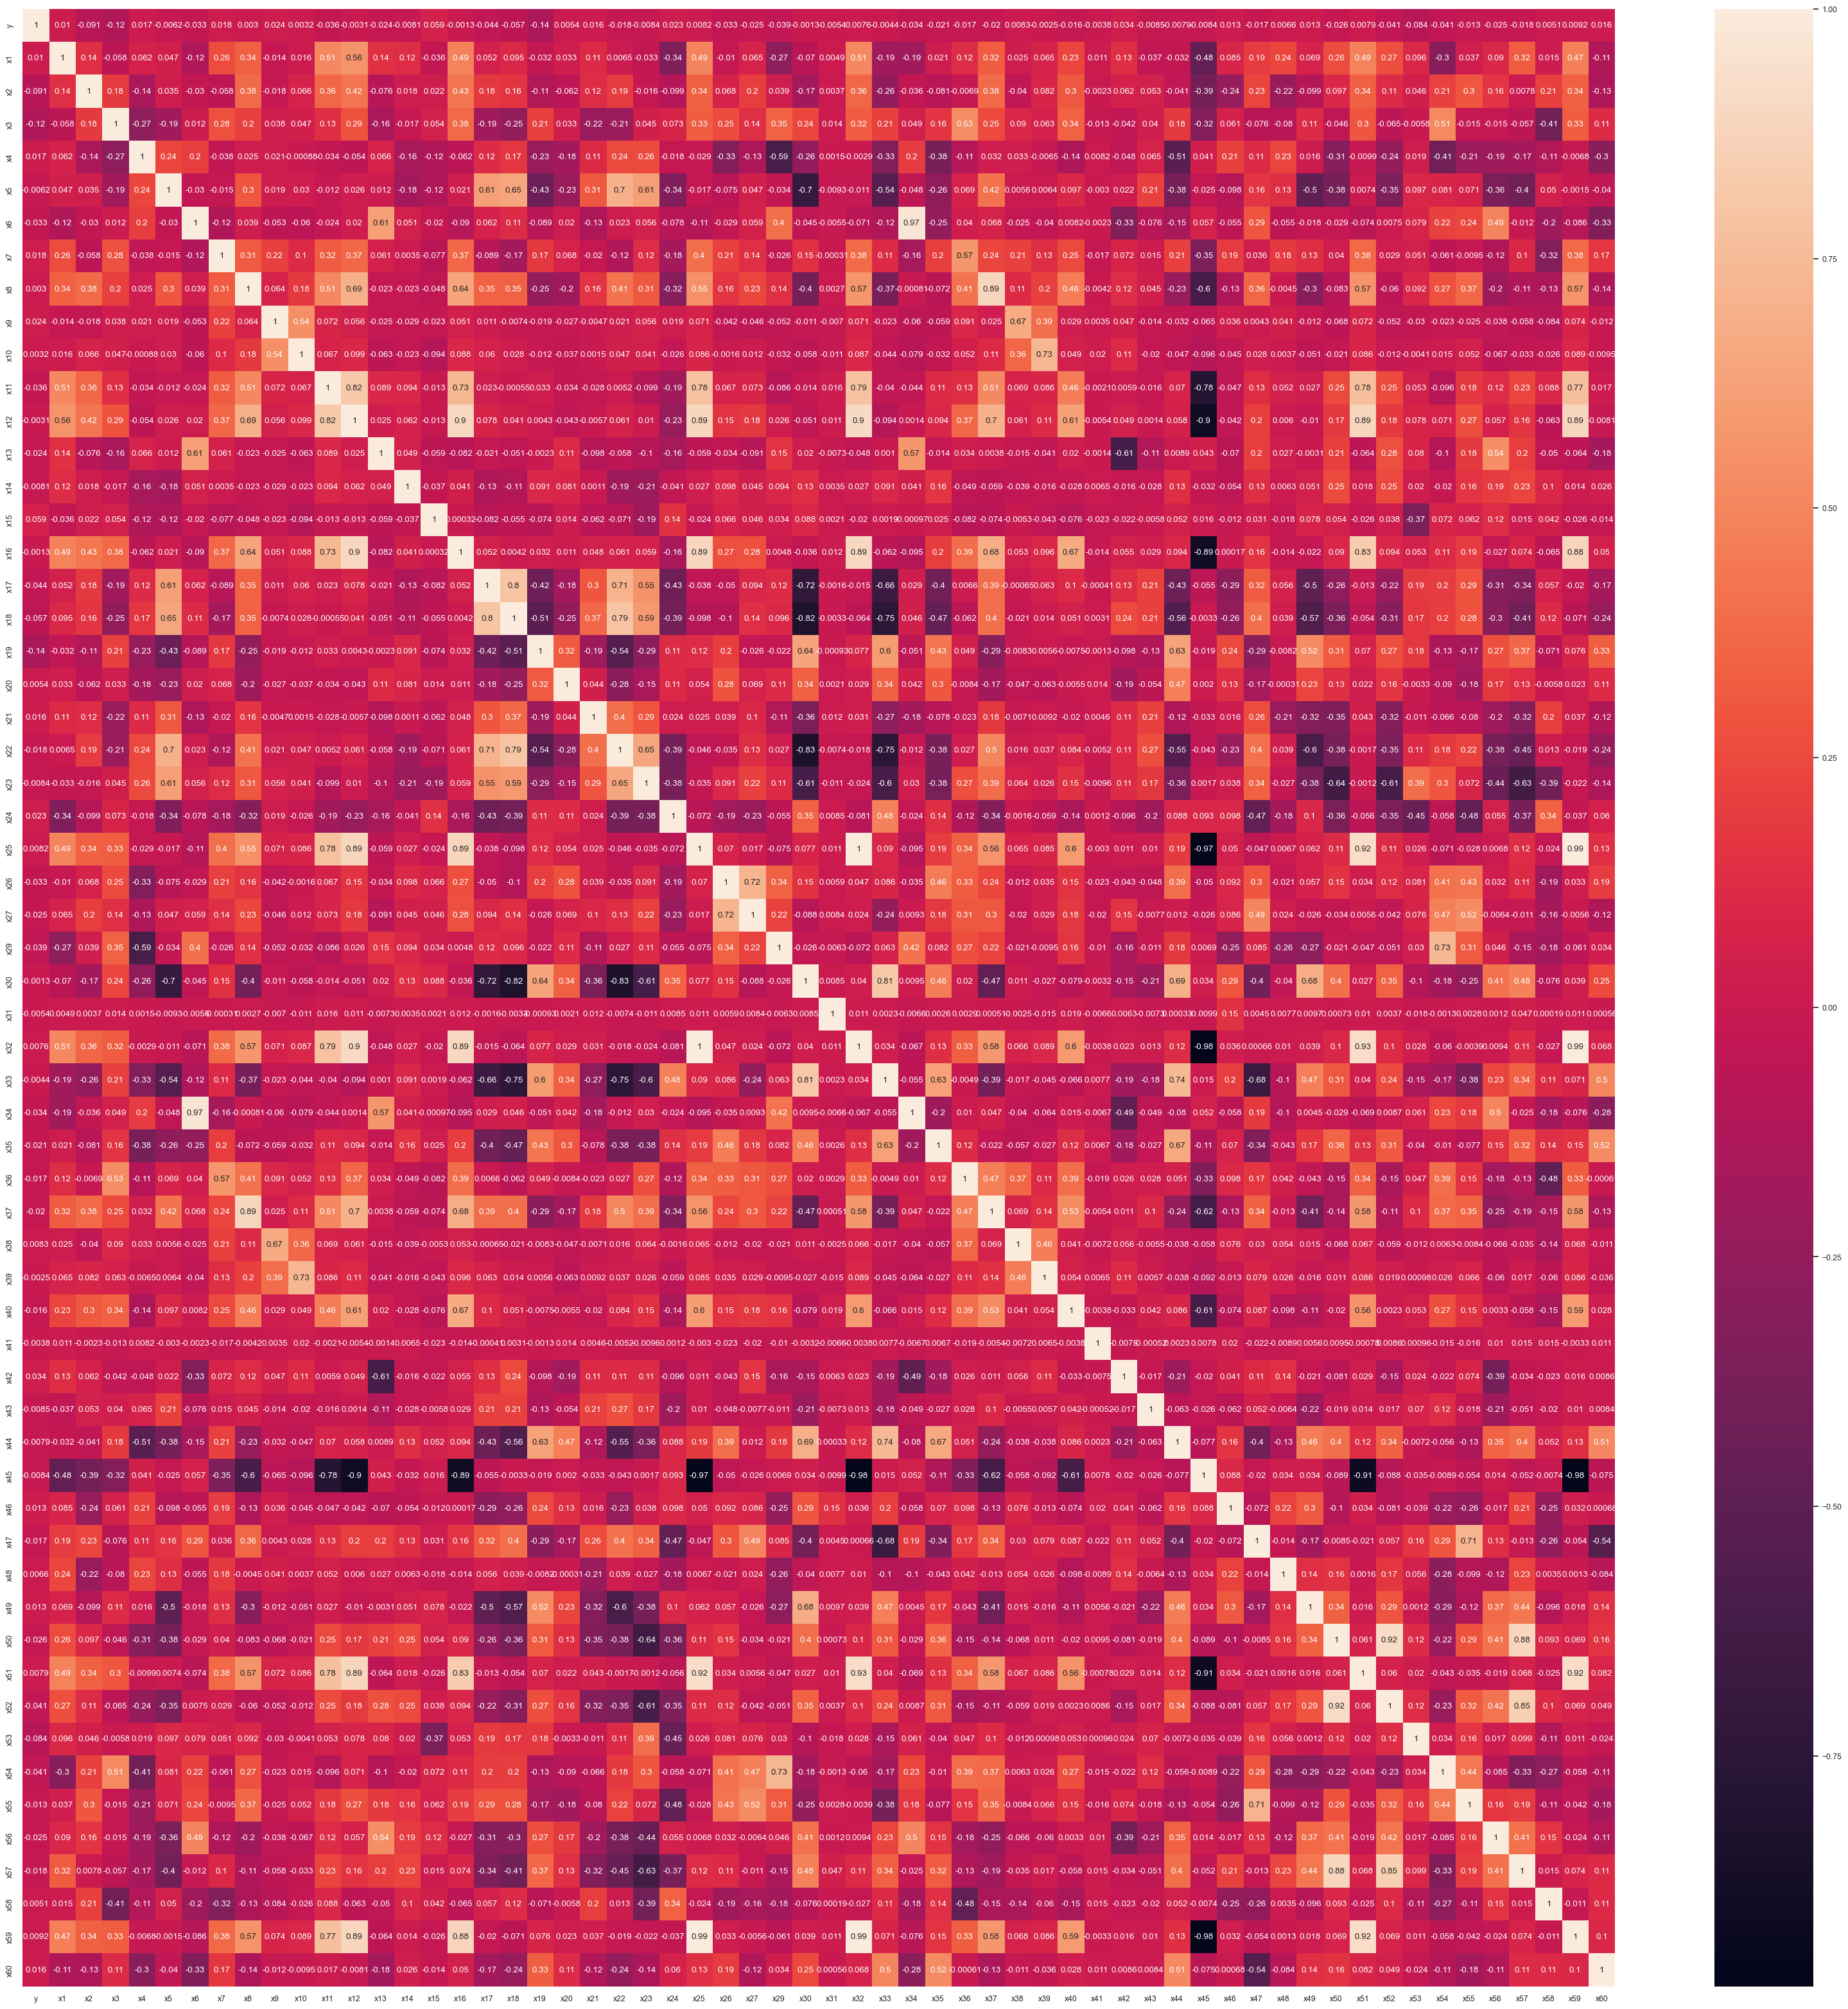

In [47]:
# Check the correlations by `sns.heatmap`
# If corr >= 0.3, positive-correlated and if corr >= 0.7, high correlated
# If corr <= -0.3, negative-correlated and if corr <= -0.7, high correlated
df_corr = df.corr()

plt.figure(figsize=(40, 40))
sns.set(font_scale=0.8)
sns.heatmap(data=df_corr, annot=True)
plt.show()

In [ ]:
# task: sheet-break(label 1)가 발생하기 전에 이를 예측하는 것.
# 4분 전에 sheet-break를 예측하려고 한다.

In [31]:
sign = lambda x: (1, -1)[x < 0] # x가 음수면 -1, 양수면 1을 리턴함. shift의 방향을 결정

# shifting 함수
def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [33]:
# split to train, test, valid
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

# normal process 즉, negative label에 대해서만 학습할 예정이기 때문에  label이 0인 / 1인 dataset으로 분리
# 하단 코드를 잘 보면 label은 직접적으로 사용하지 않는 것을 확인할 수 있음
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1) # y는 떼어내고, 안 씀. label이 없는 unsupervised learning
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

In [36]:
# scaling
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x) # train set 중 label 0인 X만. 왜냐하면 normal process만 학습할 것임


df_valid_0_x_rescaled = scaler.transform(df_valid_0_x) # validation set 중 label 0인 X만
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1)) # validation set 전체

df_test_0_x_rescaled = scaler.transform(df_test_0_x) # test set 중 label 0인 X만
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1)) # test set 전체

In [38]:
# simple architecture autoencoder

nb_epoch = 200
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] # 59. num of predictor variables, 
encoding_dim = 32 # 32로 압축
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 59)]              0         
                                                                 
 dense_5 (Dense)             (None, 32)                1920      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 32)                544       
                                                                 
 dense_9 (Dense)             (None, 59)                1947      
                                                                 
Total params: 5,211
Trainable params: 5,211
Non-trainable p

In [39]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Epoch 1/200
92/92 [==============================] - 2s 7ms/step - loss: 0.9165 - accuracy: 0.0421 - val_loss: 0.7689 - val_accuracy: 0.0786
Epoch 2/200
92/92 [==============================] - 0s 5ms/step - loss: 0.5847 - accuracy: 0.0981 - val_loss: 0.5367 - val_accuracy: 0.1377
Epoch 3/200
92/92 [==============================] - 0s 5ms/step - loss: 0.4415 - accuracy: 0.1654 - val_loss: 0.4339 - val_accuracy: 0.1893
Epoch 4/200
92/92 [==============================] - 0s 4ms/step - loss: 0.3595 - accuracy: 0.2342 - val_loss: 0.3635 - val_accuracy: 0.2539
Epoch 5/200
92/92 [==============================] - 0s 4ms/step - loss: 0.3076 - accuracy: 0.2758 - val_loss: 0.3233 - val_accuracy: 0.2970
Epoch 6/200
92/92 [==============================] - 0s 5ms/step - loss: 0.2790 - accuracy: 0.3016 - val_loss: 0.3011 - val_accuracy: 0.3161
Epoch 7/200
92/92 [==============================] - 0s 4ms/step - loss: 0.2621 - accuracy: 0.3307 - val_loss: 0.2862 - val_accuracy: 0.3377
Epoch 8/200
9

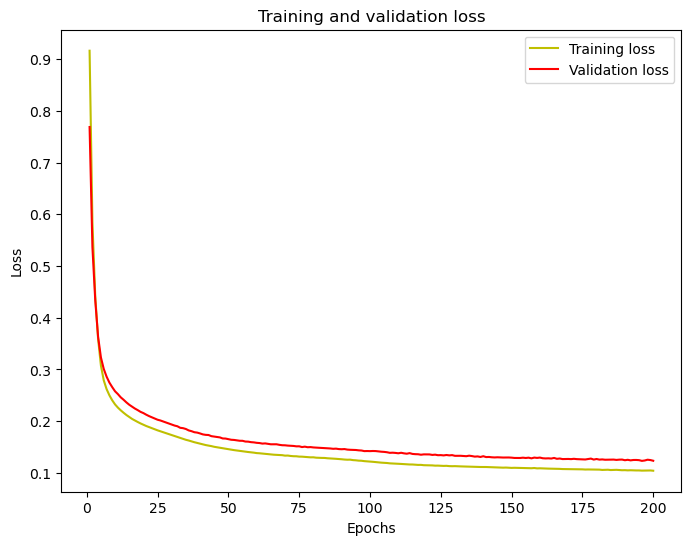

In [42]:
# Epoch에 따른 loss
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

normal process(label 0)에 대해서 reconstruction을 잘 하도록 학습했다.  
이후에 데이터를 넣었을 때, loss가 낮으면(= reconstruction이 잘 되었으면) 0으로 분류하고 아니면 1로 분류할 수 있다.  
이때 "loss가 어느 정도 수준 이상일 때를 1로 분류할까?"를 정해야 한다.

### 예시

이 코드를 통해 다음과 같은 작업을 할 수 있습니다:

1. **검증 세트**에서 Autoencoder의 **재구성 오류**를 계산합니다.
2. 재구성 오류에 기반하여 **정밀도-재현율 곡선**을 플로팅하고, 다양한 임계값에서의 성능을 확인합니다.
3. **최적의 임계값**을 선택하여, 재구성 오류가 그 임계값을 초과할 경우 이를 **희귀 이벤트(예: sheet-break)**로 분류합니다.

### 요약

이 코드는 Autoencoder 모델을 사용하여 **희귀 이벤트 탐지(rare event detection)**를 수행하는 방법을 보여줍니다. 재구성 오류가 낮으면 정상적인 데이터(0), 재구성 오류가 높으면 희귀 이벤트(1)로 분류합니다. 이 때, **정밀도-재현율 곡선**을 사용하여 적절한 임계값을 선택하는 방법을 시각적으로 분석하고 있습니다.

In [53]:
# valid_x에 대한 reconstruced data
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled) 
# original data와 reconstruced data의 MSE 즉, reconstruction error
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1) 
                                                                                   
# error 유무를 저장할 dataframe 생성
error_df = pd.DataFrame({'Reconstruction_error': mse, # reconstruction error와
                        'True_class': df_valid['y']}) # 그때의 실제 고장 유무

92/92 [==============================] - 0s 962us/step


,Reconstruction_error,True_class
8475,0.040263,1
8221,0.062693,1
15483,0.120018,1
2963,0.211903,1
9101,0.045239,1
2303,3.393829,1
2645,0.084944,1
10037,0.645191,1
15709,0.132148,1
17476,0.111376,1


In [54]:
# 고장 유무에 따른 Reconstruction_error 확인 - 고장일 때
error_df[error_df['True_class'] == 1]

,Reconstruction_error,True_class
8475,0.040263,1
8221,0.062693,1
15483,0.120018,1
2963,0.211903,1
9101,0.045239,1
2303,3.393829,1
2645,0.084944,1
10037,0.645191,1
15709,0.132148,1
17476,0.111376,1


In [55]:
# 고장 유무에 따른 Reconstruction_error 확인 - 정상일 때
error_df[error_df['True_class'] == 0]

,Reconstruction_error,True_class
3703,0.060068,0
18116,0.084517,0
7586,0.071847,0
1984,0.107513,0
12799,0.092045,0
...,...,...
12913,0.030682,0
17636,0.089274,0
4711,0.267775,0
389,0.096854,0


- **정밀도(Precision):**  
  모델이 양성(positive) 으로 예측한 샘플들 중에서 실제로 양성인 비율입니다.  
  예를 들어, 모델이 sheet-break(고장)를 예측한 모든 경우 중에서 실제로 고장이 발생한 비율.  
  Precision = (True Positives) / (True Positives + False Positives)

- **재현율(Recall):**  
  실제로 양성인 샘플들 중에서 모델이 올바르게 양성으로 예측한 비율입니다.  
  즉, 실제 고장이 발생한 모든 경우 중에서 모델이 얼마나 잘 고장을 예측했는지를 나타냅니다.  
  Recall = (True Positives) / (True Positives + False Negatives)

- **임계값(Threshold):**
  모델이 예측을 양성으로 판단할 기준 점수입니다.  
  예를 들어, Autoencoder의 재구성 오류가 특정 임계값을 넘으면 고장으로 예측하는 방식입니다.  
  임계값을 변경함에 따라 정밀도와 재현율이 달라집니다.

> 임계값이 낮으면 더 많은 샘플을 양성으로 예측하지만, 그 중에 잘못된 예측(거짓 양성, False Positives)이 많아질 수 있습니다.  
> 임계값이 높으면 예측의 신뢰도는 증가하지만, 실제로 양성인 것을 놓치는 경우(거짓 음성, False Negatives)가 많아질 수 있습니다.

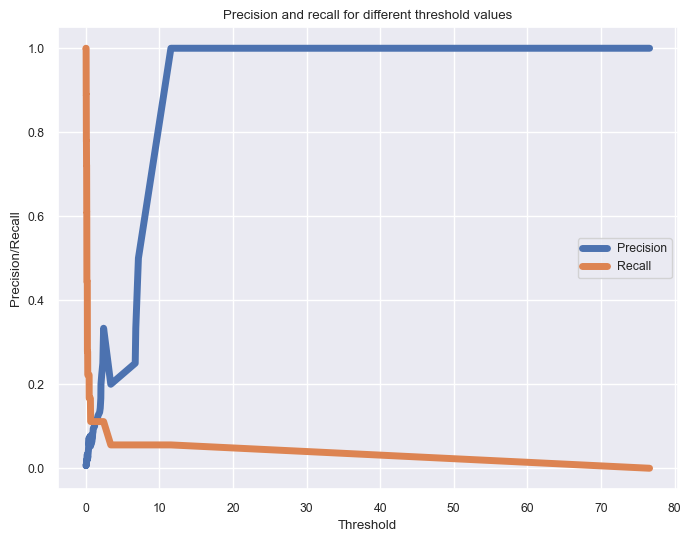

In [56]:
from sklearn.metrics import precision_recall_curve

# precision_recall_curve 함수는 함수 내에서 threshold(임계값)를 임의로 지정하면서
# 해당 임계값을 기준으로 dataset을 0 or 1로 분류했을 때의 precision과 recall 값을 리턴한다.
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)

plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

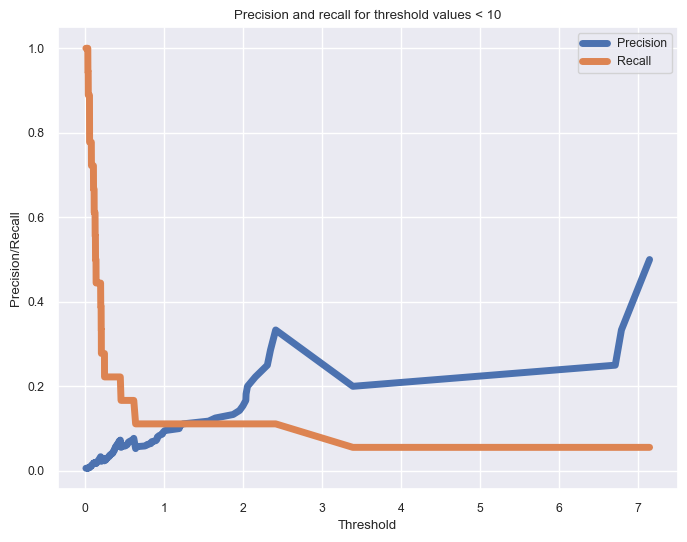

In [61]:
# threshold_rt가 10 미만인 값들만 필터링
mask = threshold_rt < 10

# threshold_rt, precision_rt, recall_rt에서 해당 값만 선택
threshold_filtered = threshold_rt[mask]
precision_filtered = precision_rt[1:][mask]  # precision_rt[1:]의 크기를 맞추기 위해 동일한 마스크 적용
recall_filtered = recall_rt[1:][mask]  # recall_rt[1:]의 크기를 맞추기 위해 동일한 마스크 적용

# 필터링된 데이터로 그래프 그리기
plt.plot(threshold_filtered, precision_filtered, label="Precision", linewidth=5)
plt.plot(threshold_filtered, recall_filtered, label="Recall", linewidth=5)
plt.title('Precision and recall for threshold values < 10')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

해당 task에서는 **고장을 예측하지 못했을 때**의 손실이 매우 크다.  
따라서 FP(고장이 아닌데, 고장이라고 예측)가 조금 높아지더라도 FN(고장인데, 고장이 아니라고 예측 -> 결국 고장나게 됨)을 낮추는 것이 중요하다.  

> 임계값이 낮으면 더 많은 샘플을 양성으로 예측하지만, 그 중에 잘못된 예측(거짓 양성, False Positives)이 많아질 수 있습니다.  
> 임계값이 높으면 예측의 신뢰도는 증가하지만, 실제로 양성인 것을 놓치는 경우(거짓 음성, False Negatives)가 많아질 수 있습니다.

따라서 임계값을 낮추는 방향으로 판단하는 것이 적절하다.  
즉 FP를 늘리는 방향으로 가야 되니까, precision이 낮아지는 방향 또는 recall이 높아지는 방향으로 판단하면 된다.  

FP인 경우에는 그냥 기계 점검 한 번 더 했다고 치고, 잠깐 멈추는 시간 만큼만 손해보면 된다.  
FN인 경우에는 FP로 인한 기계 점검으로 발생하는 조금의 손해는 줄일 수 있지만, 실제 고장으로 인한 큰 손해를 보게 된다.

In [63]:
'''cf.
precision   | TP / (TP + FP)
recall      | TP / (TP + FN)
f1-score    | harmonic mean of precision and recall
              (2 * (precision * recall)) / (precision + recall)
              일반적으로 precision과 recall은 trade-off 관계라서 이를 절충할 수 있도록 한 개념임
support     | 각 class의 sample count
accuracy    | (TP + TN) / (TP + TN + FP + FN)
macro avg   | arithmatic mean of precision(각 class들의 precision 평균)
'''

'cf.\nprecision   | TP / (TP + FP)\nrecall      | TP / (TP + FN)\nf1-score    | harmonic mean of precision and recall\n              (2 * (precision * recall)) / (precision + recall)\n              일반적으로 precision과 recall은 trade-off 관계라서 이를 절충할 수 있도록 한 개념임\nsupport     | 각 class의 sample count\naccuracy    | (TP + TN) / (TP + TN + FP + FN)\nmacro avg   | arithmatic mean of precision(각 class들의 precision 평균)\n'

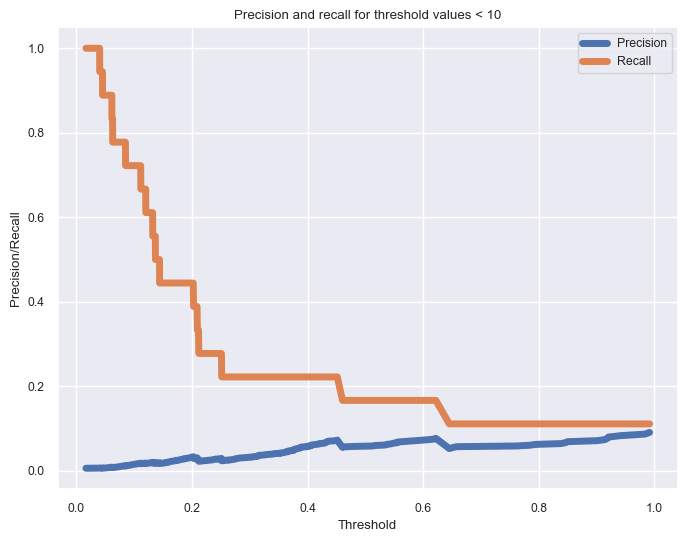

In [68]:
# precision이 낮고, recall이 높은 부분을 확인하기 위해서 다시 필터링

# threshold_rt가 1 미만인 값들만 필터링
mask = threshold_rt < 1

# threshold_rt, precision_rt, recall_rt에서 해당 값만 선택
threshold_filtered = threshold_rt[mask]
precision_filtered = precision_rt[1:][mask]  # precision_rt[1:]의 크기를 맞추기 위해 동일한 마스크 적용
recall_filtered = recall_rt[1:][mask]  # recall_rt[1:]의 크기를 맞추기 위해 동일한 마스크 적용

# 필터링된 데이터로 그래프 그리기
plt.plot(threshold_filtered, precision_filtered, label="Precision", linewidth=5)
plt.plot(threshold_filtered, recall_filtered, label="Recall", linewidth=5)
plt.title('Precision and recall for threshold values < 10')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# threshold를 0.4로 결정.

Now, we will perform classification on the test data.
> We should not estimate the classification threshold from the test data. It will result in overfitting.

115/115 [==============================] - 0s 2ms/step


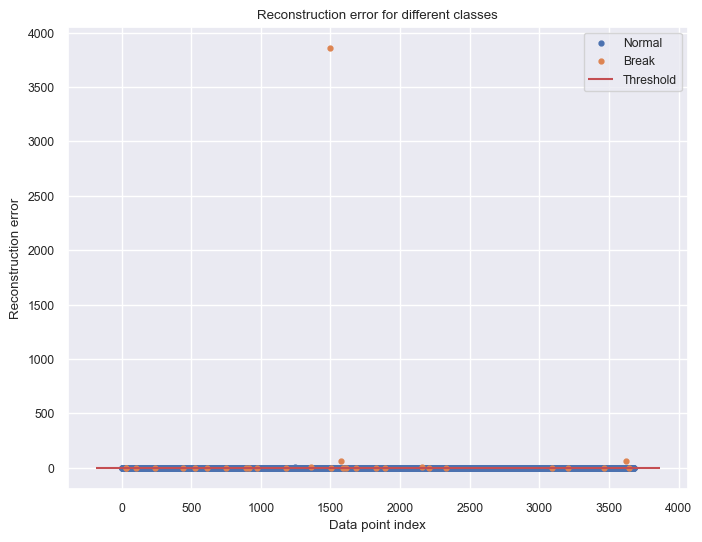

In [69]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.4
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

115/115 [==============================] - 0s 2ms/step


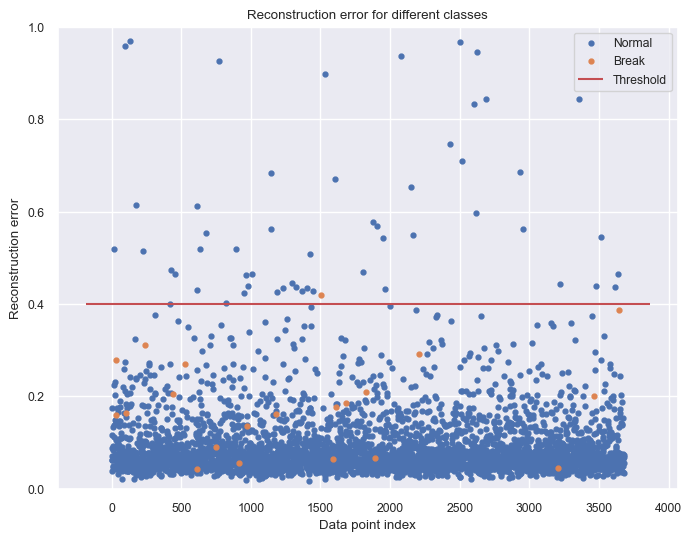

In [74]:
# y값 필터링
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                              'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()

threshold_fixed = 0.4  # 고정 임계값
groups = error_df_test.groupby('True_class')  # True_class별로 그룹화

fig, ax = plt.subplots()

# 각 클래스 그룹에 대해 점들을 플로팅
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Break" if name == 1 else "Normal")

# 고정된 임계값을 빨간 선으로 표시
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

# Y축 범위를 100 이하로 설정
ax.set_ylim(0, 1)

# 범례, 제목, 축 레이블 설정
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

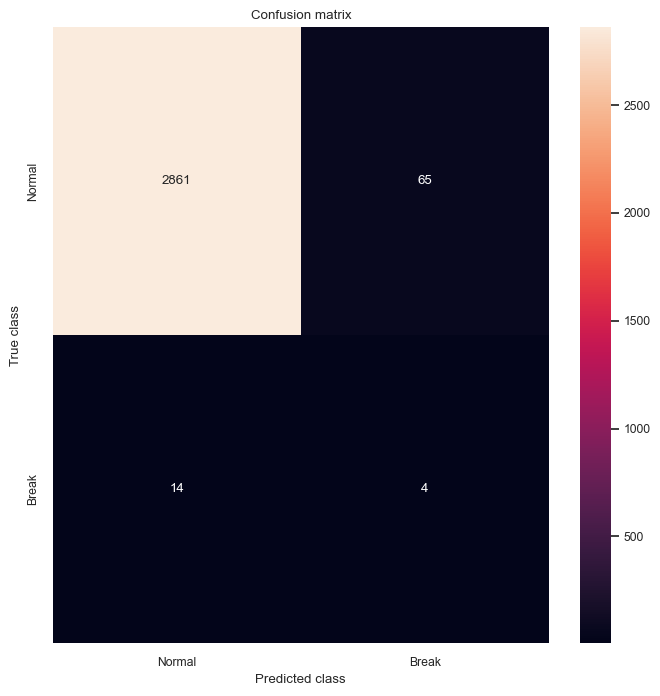

In [78]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

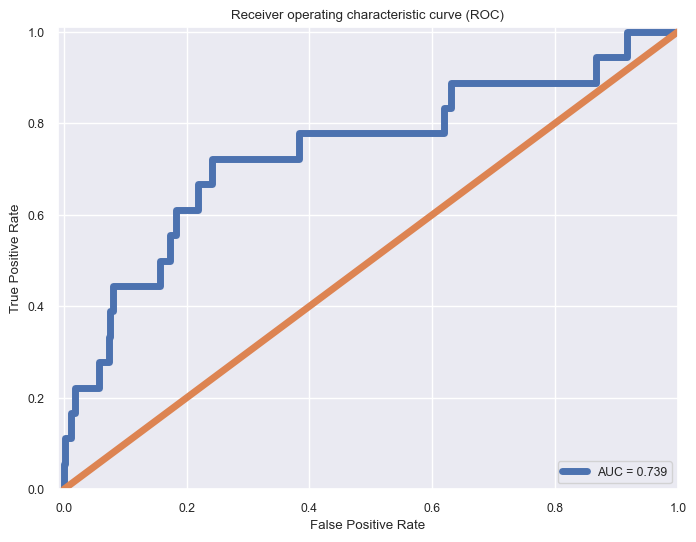

In [79]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

이 코드는 **ROC 곡선(Receiver Operating Characteristic Curve)** 을 그리고, 그 아래의 면적을 나타내는 **AUC(Area Under the Curve)** 를 계산하는 예제입니다. **ROC-AUC**는 이진 분류 모델의 성능을 평가하는 중요한 방법 중 하나로, 특히 **임계값(threshold)** 에 따라 모델의 **True Positive Rate (TPR)** 와 **False Positive Rate (FPR)** 의 변화를 시각화합니다.

### 각 부분의 설명

1. **`roc_curve` 함수**:
   ```python
   false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
   ```
   - **`roc_curve`** 함수는 모델의 예측값(여기서는 `Reconstruction_error`)과 실제 클래스(여기서는 `True_class`)를 입력받아, 다양한 **임계값(thresholds)**에 대한 **FPR(거짓 양성 비율)**과 **TPR(참 양성 비율)**을 계산합니다.
   - 반환값:
     - **`false_pos_rate` (FPR)**: 임계값에 따른 **거짓 양성 비율**(False Positive Rate, FPR). 즉, 실제로는 음성(정상)인데 모델이 양성(고장)으로 잘못 예측한 비율입니다. 
     - **`true_pos_rate` (TPR)**: 임계값에 따른 **참 양성 비율**(True Positive Rate, TPR, 재현율). 즉, 실제로 양성(고장)인 경우 중에서 모델이 양성으로 올바르게 예측한 비율입니다.
     - **`thresholds`**: ROC를 그리기 위해 사용된 임계값들의 리스트입니다.

2. **AUC 계산**:
   ```python
   roc_auc = auc(false_pos_rate, true_pos_rate)
   ```
   - **`auc`** 함수는 **FPR**과 **TPR**을 기반으로 **ROC 곡선 아래의 면적(AUC: Area Under the Curve)**을 계산합니다.
   - **AUC**는 모델이 얼마나 잘 분류하는지를 수치로 표현한 값입니다. AUC 값이 1에 가까울수록, 모델의 성능이 좋다는 것을 의미합니다.

3. **ROC 곡선 플로팅**:
   ```python
   plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
   ```
   - **ROC 곡선**을 그립니다. X축은 **거짓 양성 비율(FPR)**, Y축은 **참 양성 비율(TPR)**입니다.
   - **`label='AUC = %0.3f' % roc_auc`**: AUC 값을 계산해 그래프의 범례에 표시합니다.

4. **대각선 기준선**:
   ```python
   plt.plot([0,1], [0,1], linewidth=5)
   ```
   - 이 코드는 **대각선 기준선**을 그립니다. 이 선은 **임의로 예측하는 모델(random guessing)**의 성능을 나타냅니다. 즉, FPR과 TPR이 동일한 경우입니다. **완벽한 분류기**는 이 대각선 위에 있지 않고, 대각선 위에서 벗어나 위쪽에 위치하게 됩니다. 

5. **그래프 설정**:
   ```python
   plt.xlim([-0.01, 1])
   plt.ylim([0, 1.01])
   plt.legend(loc='lower right')
   plt.title('Receiver operating characteristic curve (ROC)')
   plt.ylabel('True Positive Rate')
   plt.xlabel('False Positive Rate')
   plt.show()
   ```
   - **X축**과 **Y축**의 범위를 설정하고, 그래프의 제목과 축 레이블을 설정합니다.
   - **범례**는 오른쪽 아래에 위치하도록 설정합니다(`loc='lower right'`).
   - **X축**은 **FPR(거짓 양성 비율)**, **Y축**은 **TPR(참 양성 비율)** 을 나타냅니다.

### ROC-AUC의 의미

- **ROC 곡선**은 모델의 **재현율(Recall, TPR)** 과 **특이도(Specificity)** 간의 트레이드오프를 시각화한 것입니다. **FPR(거짓 양성 비율)** 과 **TPR(참 양성 비율)** 의 상관관계를 다양한 임계값에서 확인할 수 있습니다.
  
- **AUC(Area Under the Curve)** 는 ROC 곡선 아래의 면적을 나타내며, **모델의 정확도**를 평가하는 중요한 지표입니다. AUC 값은 0에서 1 사이의 값을 가지며, 다음과 같은 의미를 가집니다:
  - **1.0**: 완벽한 분류기 (모델이 모든 양성과 음성을 완벽하게 구분).
  - **0.5**: 임의로 예측하는 모델 (random guessing)과 동일한 성능.
  - **0.5 미만**: 모델이 오히려 양성과 음성을 반대로 예측하고 있음.

### 전체 코드의 목적

이 코드는 **Autoencoder** 모델을 사용하여 계산된 **재구성 오류(Reconstruction Error)** 를 기반으로 **고장 여부를 예측**하는 이진 분류 문제에서, 모델의 성능을 **ROC-AUC(Receiver Operating Characteristic - Area Under Curve)** 를 통해 평가하는 것입니다. **ROC-AUC**는 임계값을 조정하면서 **TPR**과 **FPR**의 변화를 시각화하고, 모델이 얼마나 잘 분류하는지를 평가하는데 중요한 도구입니다.

* * *
임계값 조정

115/115 [==============================] - 0s 2ms/step


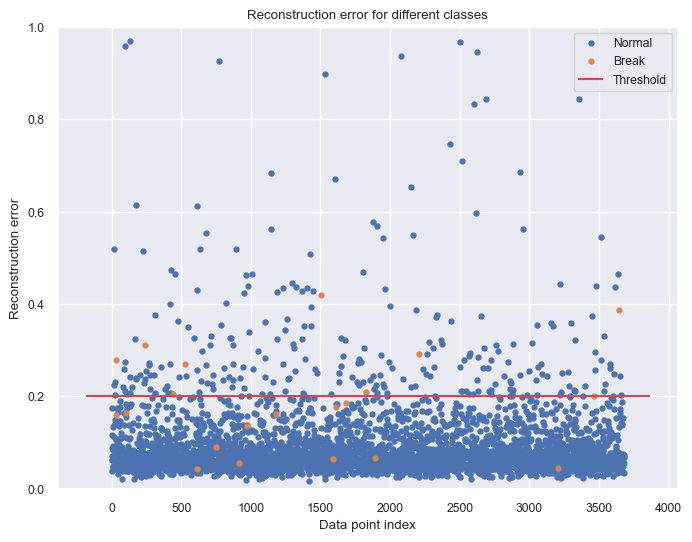

In [80]:
# y값 필터링
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                              'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()

threshold_fixed = 0.2  # 고정 임계값
groups = error_df_test.groupby('True_class')  # True_class별로 그룹화

fig, ax = plt.subplots()

# 각 클래스 그룹에 대해 점들을 플로팅
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Break" if name == 1 else "Normal")

# 고정된 임계값을 빨간 선으로 표시
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

# Y축 범위를 100 이하로 설정
ax.set_ylim(0, 1)

# 범례, 제목, 축 레이블 설정
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

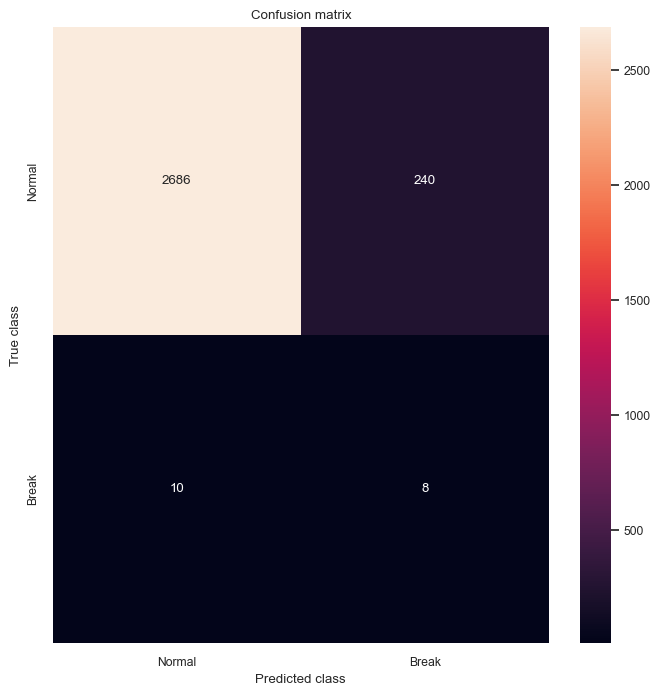

In [81]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

FN 비용 = 고장이 안 날 상황인데, 날 거라고 예측해서 잠시 점검하는 비용 = 회 당 1,000\\$  
PN 이득 = 고장이 날 상황인데, 날 거라고 예측해서 고장을 피해감으로 인해 아낀 비용 = 회 당 40,000\\$

임계값이 0.4일 때: $FN=65, PN=4$
- 총이익 $ = (4*40000) - (65*1000) = 95,000\$ $

임계값이 0.2일 때: $FN=240, PN=8$
- 총이익 $ = (8*40000) - (240*1000) = 80,000\$ $

> 임계값을 낮췄을 때 총이익이 감소하므로 임계값을 0.4로 유지하는 것이 적절한 판단임.